**Feature extractor to extract features of Rabbits**

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

**Feature Extraction Dataset** 
The dataset for feature extraction can be found [here: ](https://drive.google.com/drive/folders/1C3NMJ24akHAj2SDKdQ_rPZtogUAKOcjO?usp=sharing)

In [ ]:
BATCH_SIZE = 4

In [ ]:
# the training transforms
data_transform = {
    'train': transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.5, 0.5, 0.5],
          std=[0.5, 0.5, 0.5]
      )
  ]),
  # the validation transforms
  'val': transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),                  
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.5, 0.5, 0.5],
          std=[0.5, 0.5, 0.5]
      )
  ])
}

data_dir = '/content/drive/MyDrive/rabbit-feature-extractor/dataset'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in ['train', 'val']
}
dataset_sizes = {
    x: len(image_datasets[x]) for x in ['train', 'val']
}
class_names = image_datasets['train'].classes

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
use_cuda, device

In [ ]:
class_names

['rabbit-0', 'rabbit-1', 'rabbit-2', 'rabbit-3', 'rabbit-4', 'rabbit-5']

**Training the model**

In [ ]:
train_loss_values = []
val_loss_values = []
train_accr_values = []
val_accr_values = []

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  

  
  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print("-"*10)

    for phase in ["train", "val"]:
      if phase == "train":
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      running_corrects = 0

      #Iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero parameter gradient 
        optimizer.zero_grad()

        #forward
        # track history if only in train
        with torch.set_grad_enabled(phase == "train"):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          

          #backward + optimize only if in training phase
          if phase == "train":
            loss.backward()
            optimizer.step()

        # Statistics 
        running_loss += loss.item() + inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
      if phase == "train":
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f"{phase} loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
      if phase == "train":
        train_loss_values.append(epoch_loss)
        train_accr_values.append(epoch_acc)
      else:
        val_loss_values.append(epoch_loss)
        val_accr_values.append(epoch_acc)

      #Deep copy the model
      if phase == "val" and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  time_elapsed = time.time() - since
  print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed %60:.0f}s")
  print(f"Best Val Acc: {best_acc:4f}")
  

  #load best model weights
  model.load_state_dict(best_model_wts)
  return model

Model as a feature extractor

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))
model_conv = model_conv.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 155MB/s] 


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Train and Evaluate

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train loss: 1.4568, Acc: 0.6432
val loss: 1.3459, Acc: 0.8511

Epoch 1/24
----------
train loss: 1.3034, Acc: 0.7930
val loss: 1.3530, Acc: 0.8723

Epoch 2/24
----------
train loss: 1.1696, Acc: 0.8656
val loss: 1.1207, Acc: 0.9149

Epoch 3/24
----------
train loss: 1.1766, Acc: 0.8833
val loss: 1.4175, Acc: 0.8723

Epoch 4/24
----------
train loss: 1.2846, Acc: 0.8546
val loss: 1.0903, Acc: 0.9362

Epoch 5/24
----------
train loss: 1.1091, Acc: 0.9361
val loss: 1.1136, Acc: 0.9149

Epoch 6/24
----------
train loss: 1.2075, Acc: 0.8744
val loss: 1.0816, Acc: 0.9787

Epoch 7/24
----------
train loss: 1.1376, Acc: 0.9097
val loss: 1.0740, Acc: 0.9362

Epoch 8/24
----------
train loss: 1.0585, Acc: 0.9471
val loss: 1.0749, Acc: 0.9362

Epoch 9/24
----------
train loss: 1.0938, Acc: 0.9449
val loss: 1.1161, Acc: 0.9362

Epoch 10/24
----------
train loss: 1.0528, Acc: 0.9515
val loss: 1.2262, Acc: 0.8723

Epoch 11/24
----------
train loss: 1.0961, Acc: 0.9229
val loss:

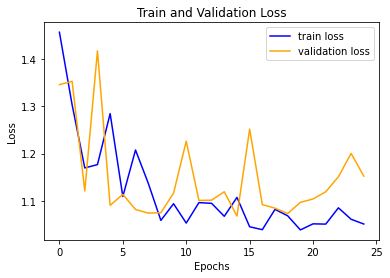

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_values, label='train loss', color='blue')
plt.plot(val_loss_values, label='validation loss', color='orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.show()

In [ ]:
!cp model_feature_extractor_weights.pt content/drive/MyDrive/rabbit-feature-extractor/dataset